# Where is the fractal?
Lorenz attractor in Julia

In [1]:
using BenchmarkTools
#using Plots

In [2]:
using DifferentialEquations

┌ Info: Recompiling stale cache file /home/etienne/.julia/compiled/v1.2/DifferentialEquations/UQdwS.ji for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1240


In [3]:
# Parameters
sigma = 10.0
rho = 28.0
beta = 8/3.;

In [221]:
# Fixed points
p1 = [-sqrt(beta*(rho-1)), -sqrt(beta*(rho-1)), rho-1];
p2 = [+sqrt(beta*(rho-1)), +sqrt(beta*(rho-1)), rho-1];
p12 = p2 .- p1

3-element Array{Float64,1}:
 16.97056274847714
 16.97056274847714
  0.0             

In [9]:
function lorenz!(du, u, p, t)
    du[1] = sigma*(u[2]-u[1])
    du[2] = u[1]*(rho-u[3]) - u[2]
    du[3] = u[1]*u[2] - beta*u[3]
    du = du ./ sqrt(sum(du.^2))  # norm
end

lorenz! (generic function with 1 method)

In [13]:
# Cube size
xy_half_size = 25
z_size = 45

45

In [15]:
# To the attractor
function burn()
    u0 = (rand(Float64, 3) .- [0.5, 0.5, 0]).*[2*xy_half_size, 2*xy_half_size, z_size]
    tspan = (0.0, 100.0)
    prob = ODEProblem(lorenz!, u0, tspan)
    tol = 1e-3
    sol = solve(prob, Tsit5(), reltol=tol, abstol=tol,
                save_everystep=false);
    return sol[end]
end

burn (generic function with 1 method)

In [14]:
@btime burn()

  3.403 ms (94871 allocations: 2.71 MiB)


3-element Array{Float64,1}:
 -5.663517855756269
 -8.436414633574675
 19.094247372557327

In [123]:
using LinearAlgebra
using Plots

In [334]:
# Define a plane
p = burn()
n = lorenz!(zeros(3), p, 0, 0)
r = p ./ sqrt(sum(p.^2))
t_y = cross(r, n)
t_y = t_y ./ sqrt(sum(t_y.^2))
t_x = cross(t_y, n)

println(p, n)

function negative_side(u, t, integrator)
    a = u .- p
    return  -sum(a .* n)
end

function projection(u)
    a = u .- p
    ux = sum(a .* t_x)
    uy = sum(a .* t_y)
    return [ux, uy]
end

function un_proj(uv)
    return p .+  t_x.*uv[1] .+  t_y.*uv[2]
end

[3.1831563956440805, 3.4694648350912694, 20.09725041702396][0.059844128654204944, 0.45328496928795214, -0.8893544944976886]


un_proj (generic function with 1 method)

In [335]:
sum(t_x.^2)

1.0000000000000002

In [336]:
function affect!(integrator)
    terminate!(integrator)
end
cb = ContinuousCallback(negative_side, nothing, affect!,
                        rootfind=true, save_positions=(false, true))

ContinuousCallback{typeof(negative_side),Nothing,typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),Float64,Int64,Nothing}(negative_side, nothing, affect!, DiffEqBase.INITIALIZE_DEFAULT, nothing, true, 10, Bool[0, 1], 2.220446049250313e-15, 0)

In [337]:
# test
u0 = burn()

tspan = (0.0, 400.0)
prob = ODEProblem(lorenz!, u0, tspan)

tol = 1e-3
sol = solve(prob, Tsit5(), callback=cb,
            reltol=tol, abstol=tol, save_everystep=false);

In [338]:
negative_side( sol.u[end], 0, 0 )

-0.0

In [339]:
function random_point()
    u0 = burn()

    tspan = (0.0, 400.0)
    prob = ODEProblem(lorenz!, u0, tspan)

    tol = 1e-3
    sol = solve(prob, Tsit5(), callback=cb,
                reltol=tol, abstol=tol, save_everystep=false);
    return projection( sol.u[end] )
end

random_point (generic function with 1 method)

In [340]:
points = hcat( [random_point() for _ in 1:500]... )

2×500 Array{Float64,2}:
 9.66516  1.01042  5.43753  -1.96569   …  -2.60844   -5.93698  8.14517
 2.78116  1.37424  1.53446  -0.551249     -0.727096  -1.60386  2.2043 

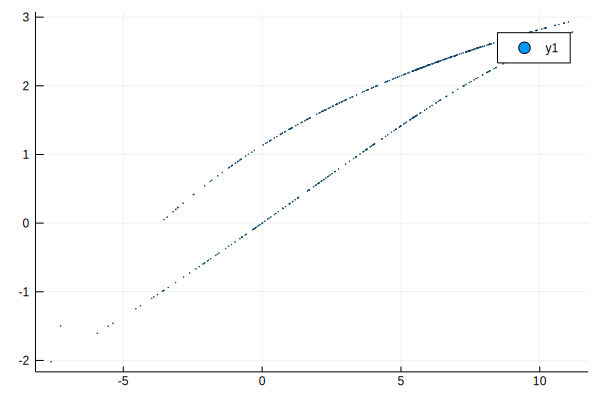

In [341]:
scatter( points[1, :], points[2, :], markersize=.11 )

In [342]:
points_manifold = hcat( [burn() for _ in 1:1000]... )
x, y, z = points_manifold[1, :], points_manifold[2, :], points_manifold[3, :];

In [343]:
xyz = hcat([un_proj(uv) for uv in eachcol(points)]...);

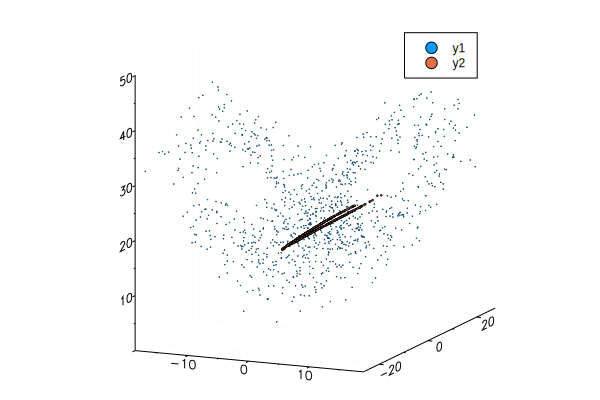

In [344]:
scatter(x, y, z, markersize=.11)
scatter!(xyz[1, :], xyz[2, :], xyz[3, :], markersize=.6)

In [69]:
# Run the solver and fill the cube
function populate!(cube)

    u0 = burn()

    tspan = (0.0, 200.0)
    prob = ODEProblem(lorenz!, u0, tspan)

    tol = 1e-6
    sol = solve(prob, Tsit5(), #callback=cb,
                reltol=tol, abstol=tol, saveat=dt);

    #saved_event_idx
    #println("sol size: ", size(sol.u))

    for xyz in sol.u
        ijk = to_ijk(xyz)
        cube[ijk] = get(cube, ijk, (0, -1.0)) .+ (1, 0)
    end
    
end

populate! (generic function with 1 method)

In [68]:
# Init the cube
cube = Dict{Tuple{Int, Int, Int}, Tuple{Int64, Float64}}()

Dict{Tuple{Int64,Int64,Int64},Tuple{Int64,Float64}} with 0 entries

In [75]:
for k in 1:500
    populate!(cube)
    print("\rcube size:  ", length(cube), "\t k: ", k)
end
println("\n min, max= ", extrema([ x[1] for x in values(cube)]))
println("c min, max= ", extrema([ x[2] for x in values(cube)]))

cube size:  981596	 k: 500
 min, max= (1, 55)
c min, max= (-1.0, 2.0)


In [ ]:
varinfo(r"cube")

In [76]:
p12 = p2 .- p1
p12_norm = sqrt(sum(p12.^2))
p12 = p12./p12_norm;

function conditions(out, u, t, integrator)
    a1 = u .- p1
    a2 = u .- p2
    out[1] = -sum(-a1.*p12)
    out[2] = -sum(a2.*p12)
end

saved_event_idx = [0, ]
function affect!(integrator, idx)
    #global saved_event_idx
    saved_event_idx[1] = idx
    terminate!(integrator)
end
#cb = ContinuousCallback(condition, affect!, rootfind=false);
cb = VectorContinuousCallback(conditions, affect!, nothing,
                              2, rootfind=false,
    save_positions=(false, false))

VectorContinuousCallback{typeof(conditions),typeof(affect!),Nothing,typeof(DiffEqBase.INITIALIZE_DEFAULT),Float64,Int64,Nothing}(conditions, affect!, nothing, 2, DiffEqBase.INITIALIZE_DEFAULT, nothing, false, 10, Bool[0, 0], 2.220446049250313e-15, 0)

In [77]:
# Same for the 3 coordinates
function to_xyz(ijk)
    i, j, k = ijk
    x = i*voxel_size - xy_half_size
    y = j*voxel_size - xy_half_size
    z = k*voxel_size
   return  x, y, z
end

to_xyz (generic function with 1 method)

## colors
http://juliagraphics.github.io/ColorSchemes.jl/stable/

In [81]:
using ColorSchemes

In [82]:
ColorSchemes.plasma

In [50]:
# Save to text file
outfile = "data/colored_lorenz_whereDoYouGo01.xyz"
open(outfile, "w") do file
    for (ijk, counts) in cube
        if counts[1] >= 3
            alpha = counts[2] - 1
            rgb = get(ColorSchemes.plasma, alpha)
            println(file, join([ijk..., rgb.r, rgb.g, rgb.b], ' '))
        end
    end
end

Next job is for PotreeConvertor:
- [Install PotreeConvertor](https://github.com/potree/PotreeConverter)

        cmake -DCMAKE_BUILD_TYPE=Release -DLASZIP_INCLUDE_DIRS=~/Projets/strange_attractor/lastools/LASzip/dll -DLASZIP_LIBRARY=~/Projets/strange_attractor/lastools/LASzip/build/src/liblaszip.so ..
        # copy ./PotreeConverter/resources/page_template to your binary working directory.
        
        
- Path to use     PotreeConverter:

        export PATH="../PotreeConvertor/master/build/PotreeConverter/:$PATH"

- Command to convert:

        PotreeConverter -p --page-template ./page_template/ -i lorenz_v02.xyz
    
        PotreeConverter -f xyzrgb -color-range 1 -i colored_lorenz_v01.xyz
        
and for [Potree](http://potree.org/):

--> [a white Lorenz Attractor](https://xdze2.github.io/chaotic-clouds/white_lorenz.html)


![screenshot](./images/thewhitebutterfly.png)

## Draft
using events

In [ ]:
p12 = p2 .- p1
p12_norm = sqrt(sum(p12.^2))
p12 = p12./p12_norm;

function conditions(out, u, t, integrator)
    a1 = u .- p1
    a2 = u .- p2
    out[1] = -sum(-a1.*p12)
    out[2] = -sum(a2.*p12)
end

saved_event_idx = [0, ]
function affect!(integrator, idx)
    saved_event_idx[1] = idx
    terminate!(integrator)
end
#cb = ContinuousCallback(condition, affect!, rootfind=false);
cb = VectorContinuousCallback(conditions, affect!, nothing,
                              2, rootfind=false, save_positions=(true, false))

In [ ]:
u0 = burn()

tspan = (0.0, 200.0)
prob = ODEProblem(lorenz!, u0, tspan)

tol = 1e-8
sol_stop = solve(prob, OwrenZen5(), callback=cb,
                 reltol=tol, abstol=tol, saveat=dt);

saved_event_idx

In [ ]:
sol_stop

In [ ]:
to_ijk.(sol_stop.u)

In [ ]:
plot(sol[2, :], sol[3, :], xlabel="y", ylabel="z")
scatter!([p1[2], ], [p1[3], ], label="p1")
scatter!([p2[2], ], [p2[3], ], label="p2")
plot!(sol_stop[2, :], sol_stop[3, :], color=:red)

In [ ]:
function to_plan()
    
    u0 = burn()
    tspan = (0.0, 160.0)
    prob = ODEProblem(lorenz!, u0, tspan)

    tol = 1e-7
    sol_stop = solve(prob, Tsit5(), callback=cb,
        reltol=tol, abstol=tol);
    return project(sol_stop[end])[1:2]
end

In [ ]:
poincarre = hcat([to_plan() for i in 1:5000]...);

In [ ]:
scatter(poincarre[1, :], poincarre[2, :], markersize=2, markerstrokewidth = 0,
            markeralpha = 0.6, xlabel="y", ylabel="x")
xaxis!(lims=(0, 5))

In [ ]:
u0 = burn()

tspan = (0.0, 1000.0)
prob = ODEProblem(lorenz!, u0, tspan)

tol = 1e-7
sol = solve(prob, Tsit5(), reltol=tol, abstol=tol);

In [ ]:
outfile = "data/lorenz_v01.xyz"
open(outfile, "w") do file
  for s in sol.u
    println(file, "$(s[1]) $(s[2]) $(s[3])")
  end
end

In [ ]:
CSV.write("hello.txt", rand(3, 3))

In [ ]:
?yaxis!#(lims=(1, 6))

In [ ]:
@gif for theta in range(0, stop = 360, length = 150)
    plot3d(sol[1, :], sol[2, :], sol[3, :],
           camera=(theta, 10))
end

In [ ]:
plot(sol[1, :], sol[3, :])

In [ ]:
u0 = [1.0; 0.0; 0.0]
tspan = (0.0, 40.0)
prob = ODEProblem(lorenz!, u0, tspan)
sol1 = solve(prob);
sol2 = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

In [ ]:
sol_OZ4 = solve(prob, OwrenZen4());
plot(sol_OZ4, linewidth=1)

In [ ]:
sol_RK4 = solve(prob, RK4(), reltol=1e-8, abstol=1e-8);
plot(sol_RK4, linewidth=1)

In [ ]:
plot(sol_RK4[2, :], sol_RK4[3, :])

In [ ]:
plot(sol_RK4.u[], linewidth=1)

In [ ]:
sol_RK4 = solve(prob, OwrenZen3(), reltol=1e-8, abstol=1e-8);
plot(sol_RK4, linewidth=1)

In [ ]:
sol_RK4 = solve(prob, Feagin14(), reltol=1e-8, abstol=1e-8);
plot(sol_RK4, linewidth=1)